In [2]:
import os
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import ast
from pathlib import Path
from collections import defaultdict

In [3]:
output_dir =  'data'
os.makedirs('data', exist_ok=True)

genre_mapping = {
    "hip-hop": "hip-hop",
    "hip hop": "hip-hop",
    "hiphop": "hip-hop",
    "metal": "metal",
    "rock": "rock",
    "pop": "pop",
    "country": "country",
}

def clean_text(text):
    allowed = r'[^a-zA-Zа-яА-ЯёЁ0-9\s.,:;!?\'"\-\(\)\[\]\\/ $%#&]'
    return re.sub(allowed, '', text)

def standardize_genres(df: pl.DataFrame, genre_map: dict[str, str] = None) -> pl.DataFrame:
    genre_col = df.columns[0]
    # Normalize genre values safely
    df = df.with_columns([
        pl.col(genre_col).map_elements(normalize_genre).alias(genre_col)
    ])
    print(f"Unique genres before mapping: {df[genre_col].unique().to_list()}")
    if genre_map:
        # Apply genre mapping without changing unmapped genres
        df = df.with_columns([
            pl.col(genre_col).map_elements(lambda g: genre_map.get(g, g)).alias(genre_col)
        ])
    df = df.drop_nulls([genre_col])
    df = df.unique()
    return df

def normalize_genre(genre: str) -> str:
    try:
        genre = str(genre).lower().strip()
        genre = genre.replace("_", " ")
        return genre
    except Exception as e:
        print(f"Genre normalization failed for value: {genre} | Error: {e}")
        return "unknown"

def merge_all_csvs(csv_paths: list[str], genre_mapping: dict[str, str]) -> pl.DataFrame:
    dfs = []
    for path in csv_paths:
        df = pl.read_csv(path)
        print(f"File: {path}, Shape: {df.shape}, Columns: {df.columns}")
        try:
            df = standardize_genres(df, genre_mapping)
            dfs.append(df)
        except Exception as e:
            print(f"Error processing {path}: {e}")
    merged = pl.concat(dfs, how="vertical")
    return merged.unique()

def extract_all_genres(folder_path: str) -> set[str]:
    """Scan every *.csv in folder_path and collect all unique genres."""
    genres: set[str] = set()
    for csv in Path(folder_path).glob("*.csv"):
        df = pl.read_csv(csv)
        genre_col = df.columns[0]         
        genres.update(df[genre_col].unique().to_list())
    return genres

Data from https://github.com/etarakci/music-genre-prediction/tree/master

In [4]:
df = pl.read_csv('source_data/genre_lyrics_data.csv') 
df

,genre_name,lyrics_cleaned
i64,str,str
0,"""acoustic""","""well you done done me and you …"
1,"""acoustic""","""head under water and they tell…"
2,"""acoustic""","""will you count me in ive been …"
3,"""acoustic""","""do you hear me im talking to y…"
4,"""acoustic""","""the strands in your eyes that …"
…,…,…
6728,"""world-music""","""every time i fall down on my f…"
6729,"""world-music""","""and let this be a sacrifice le…"
6730,"""world-music""","""as the sun begins to rise in t…"


In [13]:
df = pl.read_csv('source_data/genre_lyrics_data.csv') 
df_filtered = df.select([
    pl.col("genre_name")
    .map_elements(normalize_genre) 
    .alias("genre"),
    
    pl.col("lyrics_cleaned")
    .map_elements(lambda x: clean_text(x).replace('"', '') if isinstance(x, str) else '')
    .alias("lyrics")
])
df_standardized = standardize_genres(df_filtered, genre_mapping)
output_path = os.path.join(output_dir, "genre_lyrics_data.csv")
df_standardized.write_csv(output_path)
print(f"Filtered CSV saved to: {output_path}")
df_standardized

Unique genres before mapping: ['edm', 'new-age', 'techno', 'j-dance', 'k-pop', 'hip-hop', 'progressive-house', 'metal', 'folk', 'country', 'gospel', 'malay', 'drum-and-bass', 'house', 'salsa', 'club', 'j-idol', 'singer-songwriter', 'afrobeat', 'funk', 'latin', 'emo', 'french', 'turkish', 'reggaeton', 'rock-n-roll', 'deep-house', 'show-tunes', 'punk-rock', 'power-pop', 'disco', 'opera', 'dance', 'grunge', 'soul', 'guitar', 'trance', 'breakbeat', 'black-metal', 'death-metal', 'brazil', 'world-music', 'goth', 'mandopop', 'psych-rock', 'hard-rock', 'punk', 'indian', 'heavy-metal', 'piano', 'anime', 'pop', 'j-pop', 'blues', 'industrial', 'electro', 'jazz', 'ambient', 'bluegrass', 'rockabilly', 'minimal-techno', 'swedish', 'mpb', 'r-n-b', 'j-rock', 'rock', 'grindcore', 'german', 'indie', 'comedy', 'dub', 'reggae', 'honky-tonk', 'electronic', 'disney', 'dubstep', 'alt-rock', 'metalcore', 'indie-pop', 'chill', 'trip-hop', 'acoustic', 'british', 'alternative', 'ska', 'synth-pop', 'hardcore', 'd

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

genre,lyrics
str,str
"""dance""","""we clawed we chained our heart…"
"""singer-songwriter""","""my babys gone and i dont know …"
"""j-dance""","""girl why dont you give our lov…"
"""punk""","""youre the fighter youve got th…"
"""country""","""the only two things in life th…"
…,…
"""blues""","""she was born in new orleans ne…"
"""piano""","""oh little jeannie you got so m…"
"""singer-songwriter""","""sane sane theyre all insane th…"


Data from https://data.mendeley.com/datasets/3t9vbwxgr5/2

In [14]:
df = pl.read_csv('source_data/tcc_ceds_music.csv') 
df

,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,night/time,shake the audience,family/gospel,romantic,communication,obscene,music,movement/places,light/visual perceptions,family/spiritual,like/girls,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
i64,str,str,i64,str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64
0,"""mukesh""","""mohabbat bhi jhoothi""",1950,"""pop""","""hold time feel break feel untr…",95,0.000598,0.063746,0.000598,0.000598,0.000598,0.048857,0.017104,0.263751,0.000598,0.039288,0.000598,0.000598,0.000598,0.000598,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.13711,"""sadness""",1.0
4,"""frankie laine""","""i believe""",1950,"""pop""","""believe drop rain fall grow be…",51,0.035537,0.096777,0.443435,0.001284,0.001284,0.027007,0.001284,0.001284,0.001284,0.118034,0.001284,0.212681,0.051124,0.001284,0.001284,0.001284,0.331745,0.64754,0.954819,0.000002,0.325021,0.26324,"""world/life""",1.0
6,"""johnnie ray""","""cry""",1950,"""pop""","""sweetheart send letter goodbye…",24,0.00277,0.00277,0.00277,0.00277,0.00277,0.00277,0.158564,0.250668,0.00277,0.323794,0.00277,0.00277,0.00277,0.00277,0.00277,0.225422,0.456298,0.585288,0.840361,0.0,0.351814,0.139112,"""music""",1.0
10,"""pérez prado""","""patricia""",1950,"""pop""","""kiss lips want stroll charm ma…",54,0.048249,0.001548,0.001548,0.001548,0.0215,0.001548,0.411536,0.001548,0.001548,0.001548,0.12925,0.001548,0.001548,0.081132,0.225889,0.001548,0.686992,0.744404,0.083935,0.199393,0.77535,0.743736,"""romantic""",1.0
12,"""giorgos papadopoulos""","""apopse eida oneiro""",1950,"""pop""","""till darling till matter know …",48,0.00135,0.00135,0.417772,0.00135,0.00135,0.00135,0.46343,0.00135,0.00135,0.00135,0.00135,0.00135,0.029755,0.00135,0.0688,0.00135,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375,"""romantic""",1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
82447,"""mack 10""","""10 million ways""",2019,"""hip hop""","""cause fuck leave scar tick toc…",78,0.00135,0.00135,0.00135,0.00135,0.00135,0.00135,0.00135,0.00135,0.391651,0.00135,0.435089,0.00135,0.00135,0.00135,0.065664,0.00135,0.889527,0.759711,0.062549,0.0,0.751649,0.695686,"""obscene""",0.014286
82448,"""m.o.p.""","""ante up (robbin hoodz theory)""",2019,"""hip hop""","""minks things chain ring bracle…",67,0.001284,0.001284,0.035338,0.001284,0.001284,0.001284,0.066324,0.203889,0.31891,0.058152,0.134955,0.001284,0.001284,0.040811,0.001284,0.001284,0.662082,0.78958,0.004607,0.000002,0.922712,0.797791,"""obscene""",0.014286
82449,"""nine""","""whutcha want?""",2019,"""hip hop""","""get ban get ban stick crack re…",77,0.001504,0.154302,0.168988,0.001504,0.039755,0.001504,0.035401,0.001504,0.356685,0.001504,0.068684,0.001504,0.001504,0.001504,0.001504,0.001504,0.663165,0.72697,0.104417,0.000001,0.838211,0.767761,"""obscene""",0.014286


In [15]:
df = pl.read_csv('source_data/tcc_ceds_music.csv') 
df_filtered = df.select([
    pl.col("genre")
    .map_elements(normalize_genre) 
    .alias("genre"),
    
    pl.col("lyrics")
    .map_elements(lambda x: clean_text(x).replace('"', '') if isinstance(x, str) else '')
    .alias("lyrics")
])
df_standardized = standardize_genres(df_filtered, genre_mapping)
output_path = os.path.join(output_dir, "tcc_ceds_music.csv")
df_standardized.write_csv(output_path)
print(f"Filtered CSV saved to: {output_path}")
df_filtered

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

Unique genres before mapping: ['rock', 'jazz', 'reggae', 'country', 'pop', 'hip hop', 'blues']
Filtered CSV saved to: data/tcc_ceds_music.csv


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

genre,lyrics
str,str
"""pop""","""hold time feel break feel untr…"
"""pop""","""believe drop rain fall grow be…"
"""pop""","""sweetheart send letter goodbye…"
"""pop""","""kiss lips want stroll charm ma…"
"""pop""","""till darling till matter know …"
…,…
"""hip hop""","""cause fuck leave scar tick toc…"
"""hip hop""","""minks things chain ring bracle…"
"""hip hop""","""get ban get ban stick crack re…"


Data from https://huggingface.co/datasets/Veucci/lyric-to-3genre

In [16]:
df = pl.read_csv('source_data/data_3genre.csv') 
df

str
"""0|I walked through the door wi…"
"""0|Vintage tee brand new phone …"
"""0|I can see you standing honey…"
"""0|We could leave the Christmas…"
"""0|Im doing good Im on some new…"
…
"""2|Oh yeah oh yeah Oh yeah Ive …"
"""2|Yeah oh oh Yeah Why you make…"
"""2|Go figure You were the trigg…"
"""2|Yeah Yeah Uh Back up on my b…"


In [17]:
genre_map = {
    "0": "pop",
    "1": "rock",
    "2": "hip-hop"
}
rows = []
with open('source_data/data_3genre.csv', 'r', encoding='utf-8') as f:
    for line in f:
        if '|' in line:
            genre_code, lyrics = line.strip().split('|', 1)
            genre = genre_map.get(genre_code.strip(), "unknown").lower()
            lyrics = clean_text(lyrics.strip())
            rows.append((genre, lyrics))

df = pl.DataFrame(rows, schema=["genre", "lyrics"])
output_path = os.path.join(output_dir, "data_3genre.csv")
df.write_csv(output_path)
print(f"CSV saved to: {output_path}")
df.head()

CSV saved to: data/data_3genre.csv


/opt/miniconda3/envs/genre-lyrics/lib/python3.10/functools.py:889: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return dispatch(args[0].__class__)(*args, **kw)


genre,lyrics
str,str
"""pop""","""I walked through the door with…"
"""pop""","""I walked through the door with…"
"""pop""","""Vintage tee brand new phone Hi…"
"""pop""","""I can see you standing honey W…"
"""pop""","""We could leave the Christmas l…"


Data from https://github.com/josch14/song-genre-classification-with-lyrics/blob/main/data/processed-data.csv

In [18]:
df = pl.read_csv('source_data/processed-data.csv') 
df

Lyric,Artist,Genres
str,str,str
"""Oh lord I'd like to know where…","""Olodum""","""Axé"""
"""Skin head Dead head Everybody …","""Olodum""","""Axé"""
"""And do And do The moment I sa…","""Carlinhos Brown""","""Axé"""
"""ALONE IN MY TIME / I FEEL MY B…","""Carlinhos Brown""","""Axé"""
"""I wanna tell you Wonderful thi…","""Carlinhos Brown""","""Axé"""
…,…,…
"""INTERNATIONAL THIEF THIEF (x3)…","""Fela Kuti""","""World Music"""
"""If you call woman African woma…","""Fela Kuti""","""World Music"""
"""Mr. follow follow Follow, fol…","""Fela Kuti""","""World Music"""


In [19]:
df = pl.read_csv('source_data/processed-data.csv') 
df_filtered = df.select([
    pl.col("Genres")
    .map_elements(normalize_genre) 
    .alias("genre"),
    
    pl.col("Lyric")
    .map_elements(lambda x: clean_text(x).replace('"', '') if isinstance(x, str) else '')
    .alias("lyrics")
])
df_standardized = standardize_genres(df_filtered, genre_mapping)
output_path = os.path.join(output_dir, "processed-data.csv")
df_standardized.write_csv(output_path)
print(f"Filtered CSV saved to: {output_path}")
df_standardized

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

Unique genres before mapping: ['trance', 'progressivo', 'tecnopop', 'hardcore', 'industrial', 'rock', 'blues', 'indie', 'k-pop/k-rock', 'gótico', 'pop/rock', 'pós-punk', 'infantil', 'gospel/religioso', 'dance', 'r&b', 'reggaeton', 'rap', 'reggae', 'funk carioca', 'pop', 'samba', 'heavy metal', 'power-pop', 'fado', 'funk', 'hip hop', 'sertanejo', 'trip-hop', 'jazz', 'ska', 'grunge', 'jovem guarda', 'pop/punk', 'folk', 'forró', 'world music', 'soul music', 'piano rock', 'romântico', 'mpb', 'clássico', 'bossa nova', 'country', 'j-pop/j-rock', 'electronica', 'tropical house', 'instrumental', 'rockabilly', 'new wave', 'house', 'soft rock', 'axé', 'psicodelia', 'punk rock', 'hard rock', 'disco', 'rock alternativo', 'new age', 'trilha sonora']
Filtered CSV saved to: data/processed-data.csv


genre,lyrics
str,str
"""rock""","""Saigon, it was all gone The sa…"
"""electronica""","""The wheel of fortune stops at …"
"""country""","""There's many a strange impulse…"
"""heavy metal""","""Blood was like paste on the wa…"
"""heavy metal""","""Rain wets your body - rain wet…"
…,…
"""country""","""I'm looking at a star Wonderin…"
"""indie""","""Well take a step outside your …"
"""rap""","""Sometimes in life you'll fall …"


Data from https://www.kaggle.com/datasets/mateibejan/multilingual-lyrics-for-genre-classification (train + test)

In [20]:
df = pl.read_csv('source_data/multilingual_train.csv') 
df

Artist,Song,Genre,Language,Lyrics
str,str,str,str,str
"""12 stones""","""world so cold""","""Rock""","""en""","""It starts with pain, followed …"
"""12 stones""","""broken""","""Rock""","""en""","""Freedom! Alone again again alo…"
"""12 stones""","""3 leaf loser""","""Rock""","""en""","""Biting the hand that feeds you…"
"""12 stones""","""anthem for the underdog""","""Rock""","""en""","""You say you know just who I am…"
"""12 stones""","""adrenaline""","""Rock""","""en""","""My heart is beating faster can…"
…,…,…,…,…
"""bobby womack""","""i wish he didn t trust me so m…","""R&B""","""en""","""I'm the best friend he's got I…"
"""bad boys blue""","""i totally miss you""","""Pop""","""en""","""Bad Boys Blue ""I Totally Miss …"
"""celine dion""","""sorry for love""","""Pop""","""en""","""Forgive me for the things That…"


In [21]:
df = pl.read_csv('source_data/multilingual_train.csv') 
df_filtered = (
    df
    .filter(pl.col("Language").is_in(["en"]))
    .select([
        pl.col("Genre")
        .map_elements(normalize_genre) 
        .alias("genre"),
        
        pl.col("Lyrics")
        .map_elements(lambda x: clean_text(x).replace('"', '') if isinstance(x, str) else '')
        .alias("lyrics")
    ])
)
df_standardized = standardize_genres(df_filtered, genre_mapping)
output_path = os.path.join(output_dir, "multilingual_train.csv")
df_standardized.write_csv(output_path)
print(f"Filtered CSV saved to: {output_path}")
df_standardized

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

Unique genres before mapping: ['pop', 'electronic', 'metal', 'country', 'r&b', 'folk', 'jazz', 'indie', 'rock', 'hip-hop']
Filtered CSV saved to: data/multilingual_train.csv


genre,lyrics
str,str
"""pop""","""Sister, I'm not much a poet, b…"
"""pop""","""You don't really wanna let you…"
"""rock""","""Your love's a gathered storm I…"
"""metal""","""Call to the darkness, the wrat…"
"""hip-hop""","""I fly with the stars in the sk…"
…,…
"""rock""","""She says he's gone away on a s…"
"""rock""","""If I caught us after something…"
"""rock""","""I was drunk when I met you I w…"


In [22]:
df = pl.read_csv('source_data/multilingual_test.csv') 
df

Song,Song year,Artist,Genre,Lyrics,Track_id
str,i64,str,str,str,i64
"""craftsmanship""",2005,"""buck-65""","""Hip-Hop""","""Most folks spend their days da…",8294
"""come-on-out""",2012,"""the-elwins""","""Indie""","""Take your cold hands and put t…",21621
"""riot""",2013,"""bullet-for-my-valentine""","""Metal""","""Are you ready it's time for wa…",3301
"""that-s-what-girls-do""",2007,"""dream-street""","""Pop""","""You ask me why I change the co…",2773
"""believe-in-a-dollar""",2012,"""cassidy""","""Hip-Hop""","""Do you believe in magic in a y…",16797
…,…,…,…,…,…
"""too-little-too-late""",2006,"""amanda-marshall""","""Rock""","""Tuesday night - 7:30 I hear a …",23453
"""berserker""",2007,"""aurora-borealis""","""Metal""","""Elite forces cloaked in fur un…",2724
"""natural-born-killaz""",2010,"""dr-dre""","""Hip-Hop""","""[Dr. Dre] Journey with me Into…",24147


In [23]:
df = pl.read_csv('source_data/multilingual_test.csv') 
df_filtered = (
    df
    .select([
        pl.col("Genre")
        .map_elements(normalize_genre) 
        .alias("genre"),
        
        pl.col("Lyrics")
        .map_elements(lambda x: clean_text(x).replace('"', '') if isinstance(x, str) else '')
        .alias("lyrics")
    ])
)
df_standardized = standardize_genres(df_filtered, genre_mapping)
output_path = os.path.join(output_dir, "multilingual_test.csv")
df_standardized.write_csv(output_path)
print(f"Filtered CSV saved to: {output_path}")
df_standardized

Unique genres before mapping: ['pop', 'rock', 'electronic', 'hip-hop', 'r&b', 'country', 'jazz', 'metal', 'folk', 'indie']
Filtered CSV saved to: data/multilingual_test.csv


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

genre,lyrics
str,str
"""pop""","""She's been making plans to go …"
"""metal""","""It is my life, my life. I need…"
"""rock""","""I know all the little bus driv…"
"""indie""","""Have you ever met a girl that …"
"""rock""","""I do still sometimes put my ha…"
…,…
"""r&b""","""a bunch of punks hangin' out o…"
"""folk""","""Now Jack was a sailor who roam…"
"""r&b""","""I saw right through your eyes …"


Popular songs from Spotify

In [24]:
df = pl.read_csv('source_data/most_popular_spotify_songs.csv') 
df

genre,lyrics
str,str
"""Pop""","""['bring', 'me', 'higher', 'lov…"
"""Pop""","""['yeah,', 'yeah', 'oh,', 'ah',…"
"""Pop""","""['one', 'more', 'drink,', 'got…"
"""Pop""","""['(sixteen)', '(sixteen)', 'do…"
"""Pop""","""[""i'm"", 'losing', 'my', 'self'…"
…,…
"""Edm""","""['vamo', 'assim', 'segura', 'a…"
"""Edm""","""['pensa', 'numa', 'histria...'…"
"""Edm""","""[""i'm"", 'so', 'into', 'you', '…"


In [25]:
df = pl.read_csv('source_data/most_popular_spotify_songs.csv') 
def parse_and_join_lyrics(lyrics_str):
    try:
        lyrics_list = ast.literal_eval(lyrics_str)
        return " ".join(lyrics_list)
    except Exception:
        return clean_text(lyrics).replace('"', '')

df_filtered = (
    df
    .select([
        pl.col("genre")
        .map_elements(normalize_genre) 
        .alias("genre"),
        
        pl.col("lyrics")
        .map_elements(lambda x: clean_text(x).replace('"', '') if isinstance(x, str) else '')
        .alias("lyrics")
    ])
)
df_standardized = standardize_genres(df_filtered, genre_mapping)
output_path = os.path.join(output_dir, "most_popular_spotify_songs.csv")
df_standardized.write_csv(output_path)
print(f"Filtered CSV saved to: {output_path}")
df_standardized

Unique genres before mapping: ['latin', 'pop', 'r&b', 'edm', 'rap', 'rock']
Filtered CSV saved to: data/most_popular_spotify_songs.csv


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

genre,lyrics
str,str
"""rap""","""['ooh,', 'ooh,', 'ooh,', 'ow,'…"
"""rap""","""['ahh', 'eh', 'ahh', 'ohh', 'e…"
"""pop""","""['and', 'i', 'said,', 'what\\\…"
"""rap""","""['me', 'ven', 'y', 'me', 'preg…"
"""rap""","""['attention', 'deficit', 'hype…"
…,…
"""pop""","""['uh-huh,', 'uh-huh', '(yeah,'…"
"""latin""","""['no', 'lo', 'trates,', 'no', …"
"""rap""","""[don't,, don't, 'play', 'with'…"


Spotify songs

In [26]:
df = pl.read_csv("source_data/spotify_480k.csv", has_header=True)
df = df.select(["genre", "lyrics"])

df_filtered = (
    df
    .select([
        pl.col("genre")
        .map_elements(normalize_genre) 
        .alias("genre"),
        
        pl.col("lyrics")
        .map_elements(lambda x: clean_text(x).replace('"', '') if isinstance(x, str) else '')
        .alias("lyrics")
    ])
)
df_standardized = standardize_genres(df_filtered, genre_mapping)
output_path = os.path.join(output_dir, "spotify_480k.csv")
df_standardized.write_csv(output_path)
print(f"Filtered CSV saved to: {output_path}")
df_standardized

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

Unique genres before mapping: ['alternative,rock,indie', 'shoegaze,ambient,experimental', 'rock,electronic,synthpop', 'indie pop,disco,indie', 'post-punk,lo-fi', 'rock,punk,grunge', 'reggae,alternative rock,rock', 'pop rock,alternative rock,rock', 'hip hop,nu metal,pop rock', 'nu metal,thrash metal,death metal', 'melodic death metal,metal,death metal', 'rock,pop rock,hard rock', 'psychedelic rock,pop rock', 'pop rock,psychedelic rock,synthpop', 'pop punk,indie rock,emo', 'pop rock,indie pop,hip hop', 'electronic,drum and bass,house', 'dubstep,trap', 'screamo,emo,pop punk', 'metalcore,thrash metal,metal', 'folk,country,pop rock', 'house,trap,dubstep', 'jazz,country,swing', 'progressive rock,psychedelic rock,post-punk', 'alternative rock,grunge,garage rock', 'pop rock,pop,rock', 'lo-fi,dream pop,rock', 'country', 'alternative rock,heavy metal,hard rock', 'progressive rock,jazz,experimental', 'rock,blues,country', 'melodic death metal,metalcore,death metal', 'electronic,house,hip hop', 'e

genre,lyrics
str,str
"""indie rock""","""I am really special 'cause the…"
"""pop""","""[DIANE] So... [NICK] So... [DI…"
"""hip-hop""","""You told the man in the Broadw…"
"""rock,emo,pop rock""","""[Verse 1] All alone in a bar o…"
"""rock,alternative rock,indie ro…","""You took the car, it was my fa…"
…,…
"""hip-hop""","""[Intro: Fatboy SSE] Will you s…"
"""hip-hop""","""Can't do it anymore, it's too …"
"""dub,reggae""","""Yo! Yes Live from New York Cit…"


Data from https://www.kaggle.com/datasets/neisse/scrapped-lyrics-from-6-genres

In [27]:
artists_df = pl.read_csv(
    "source_data/artists-data.csv",
    encoding="utf8-lossy", 
    quote_char='"',        
    ignore_errors=True    
)
artists_df.head()

Artist,Genres,Songs,Popularity,Link
str,str,i64,f64,str
"""Ivete Sangalo""","""Pop; Axé; Romântico""",313,4.4,"""/ivete-sangalo/"""
"""Chiclete com Banana""","""Axé""",268,3.8,"""/chiclete-com-banana/"""
"""Banda Eva""","""Axé; Romântico; Reggae""",215,2.3,"""/banda-eva/"""
"""É O Tchan""","""Axé""",129,1.6,"""/e-o-tchan/"""
"""Claudia Leitte""","""Pop; Axé; Romântico""",167,1.5,"""/claudia-leitte/"""


In [28]:
lyrics_df = pl.read_csv(
    "source_data/lyrics-data.csv",
    encoding="utf8-lossy",
    quote_char='"',
    ignore_errors=True
)
lyrics_df.head()

ALink,SName,SLink,Lyric,language
str,str,str,str,str
"""/ivete-sangalo/""","""Arerê""","""/ivete-sangalo/arere.html""","""Tudo o que eu quero nessa vida…","""pt"""
"""/ivete-sangalo/""","""Se Eu Não Te Amasse Tanto Assi…","""/ivete-sangalo/se-eu-nao-te-am…","""Meu coração Sem direção Voando…","""pt"""
"""/ivete-sangalo/""","""Céu da Boca""","""/ivete-sangalo/chupa-toda.html""","""É de babaixá! É de balacubaca!…","""pt"""
"""/ivete-sangalo/""","""Quando A Chuva Passar""","""/ivete-sangalo/quando-a-chuva-…","""Quando a chuva passar Pra quê…","""pt"""
"""/ivete-sangalo/""","""Sorte Grande""","""/ivete-sangalo/sorte-grande.ht…","""A minha sorte grande foi você …","""pt"""


In [29]:
artists_df = pl.read_csv("source_data/artists-data.csv", encoding="utf8-lossy", quote_char='"', ignore_errors=True)
lyrics_df = pl.read_csv("source_data/lyrics-data.csv", encoding="utf8-lossy", quote_char='"', ignore_errors=True)
merged_df = lyrics_df.join(artists_df, left_on="ALink", right_on="Link", how="inner")
final_df = merged_df.select([
    pl.col("Genres")
    .map_elements(normalize_genre) 
    .alias("genre"),
        
    pl.col("Lyric")
    .map_elements(lambda x: clean_text(x).replace('"', '') if isinstance(x, str) else '')
    .alias("lyrics")
])
df_standardized = standardize_genres(final_df, genre_mapping)
output_path = os.path.join(output_dir, "artists_lyrics.csv")
df_standardized.write_csv(output_path)
print(f"Filtered CSV saved to: {output_path}")
df_standardized

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
/var/folders/c3/4r9yd_v5607bwfv_hxq8j6kw0000gn/T/ipykernel_60877/1677531539.py:21: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns([
/var/folders/c3/4r9yd_v5607bwfv_hxq8j6kw0000gn/T/ipykernel_60877/1677531539.py:27: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns([


Unique genres before mapping: ['rock; rock alternativo; pop/rock', 'soul music; mpb; funk', 'reggae; hip hop; gospel/religioso', 'rock; blues', 'trip-hop; electronica; tecnopop', 'heavy metal; classic rock; hard rock', 'sertanejo; mpb; axé', 'dance; electronica; house', 'indie; electronica; rock', 'romântico; trilha sonora', 'funk carioca; electronica; pagode', 'instrumental; progressivo; rock alternativo', 'punk rock; pós-punk', 'trilha sonora; infantil', 'pop; new wave; new age', 'pós-punk; punk rock; rock', 'heavy metal; hard rock; punk rock', 'reggaeton; reggae; axé', 'country; bossa nova', 'pop; pop/rock; trilha sonora', 'reggae; romântico; surf music', 'gospel/religioso; j-pop/j-rock; hard rock', 'romântico; r&b; black music', 'pós-punk; punk rock; axé', 'gospel/religioso; axé; mpb', 'mpb; romântico', 'romântico; world music; sertanejo', 'trilha sonora; romântico; pop', 'rock; romântico; folk', 'soft rock', 'progressivo; heavy metal; rock', 'trip-hop; instrumental; electronica', 

genre,lyrics
str,str
"""progressivo; rock""","""When I was a boy I thought abo…"
"""country""","""She was born to a mother truck…"
"""gospel/religioso; infantil""","""Domnio e poder Pertencem a Jes…"
"""heavy metal; rock; hard rock""","""You stole what I create Playin…"
"""dance; electronica; house""","""Hate to love it Hate to love t…"
…,…
"""rock""","""Disco, disco mystic Disco, dis…"
"""r&b; black music; funk""","""Love come quick Love come in a…"
"""mpb; samba; black music""","""Eu fico cego Meu bem, no vejo …"


### [Genius Song Lyrics](https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information) - the biggest dataset (multilingual)

In [5]:
df = pl.read_csv('source_data/song_lyrics.csv') 
df

title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
str,str,str,i64,i64,str,str,i64,str,str,str
"""Killa Cam""","""rap""","""Cam'ron""",2004,173166,"""{""Cam\\'ron"",""Opera Steve""}""","""[Chorus: Opera Steve & Cam'ron…",1,"""en""","""en""","""en"""
"""Can I Live""","""rap""","""JAY-Z""",1996,468624,"""{}""","""[Produced by Irv Gotti] [Intr…",3,"""en""","""en""","""en"""
"""Forgive Me Father""","""rap""","""Fabolous""",2003,4743,"""{}""","""Maybe cause I'm eatin And thes…",4,"""en""","""en""","""en"""
"""Down and Out""","""rap""","""Cam'ron""",2004,144404,"""{""Cam\\'ron"",""Kanye West"",""Syl…","""[Produced by Kanye West and Br…",5,"""en""","""en""","""en"""
"""Fly In""","""rap""","""Lil Wayne""",2005,78271,"""{}""","""[Intro] So they ask me ""Young …",6,"""en""","""en""","""en"""
…,…,…,…,…,…,…,…,…,…,…
"""Ocean""","""pop""","""Effemar""",2022,3,"""{}""","""[Verse 1] Dance for me now Kee…",7882842,"""en""","""en""","""en"""
"""64 Bars""","""rap""","""Rapido""",2022,4,"""{}""","""[Intro] Ja, ja [Part 1] R-A…",7882843,"""de""","""de""","""de"""
"""Raise Our Hands""","""pop""","""Culture Code, Pag & Mylo""",2016,3,"""{Elex,""Culture Code / Pag & My…","""[Verse 1] Here our purpose fee…",7882845,"""en""","""en""","""en"""


In [4]:
df = pl.read_csv('source_data/song_lyrics.csv') 
df_filtered = (
    df
    .filter(pl.col("language").is_in(["en", "ru"]))
    .select([
        pl.col("tag")
        .map_elements(normalize_genre) 
        .alias("genre"),
        
        pl.col("lyrics")
        .map_elements(lambda x: clean_text(x).replace('"', '') if isinstance(x, str) else '')
        .alias("lyrics")
    ])
)
df_standardized = standardize_genres(df_filtered, genre_mapping)
output_path = os.path.join(output_dir, "song_lyrics.csv")
df_standardized.write_csv(output_path)
print(f"Filtered CSV saved to: {output_path}")
df_filtered

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

Unique genres before mapping: ['misc', 'rap', 'pop', 'rb', 'country', 'rock']


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

Filtered CSV saved to: data/song_lyrics.csv


genre,lyrics
str,str
"""rap""","""[Chorus: Opera Steve & Cam'ron…"
"""rap""","""[Produced by Irv Gotti] [Intr…"
"""rap""","""Maybe cause I'm eatin And thes…"
"""rap""","""[Produced by Kanye West and Br…"
"""rap""","""[Intro] So they ask me Young b…"
…,…
"""pop""","""Everything is alright now Oh y…"
"""pop""","""[Verse 1] Half truth and half …"
"""pop""","""[Verse 1] Dance for me now Kee…"


In [ ]:
original_genres = extract_all_genres(output_dir)
print(f"Original genres found ({len(original_genres)}):", original_genres)
csv_files = list(Path(output_dir).glob("*.csv"))
merged_df = merge_all_csvs([str(p) for p in csv_files], genre_mapping)
merged_df.write_csv("merged_genre_lyrics.csv")
merged_df.write_parquet("all_data.parquet")
merged_genres = set(merged_df.select(merged_df.columns[0]).unique().to_series())
print(f"Merged genres found ({len(merged_genres)}):", merged_genres)
print("Merged and cleaned dataset saved.")

Original genres found (4857): {'trap; hip hop', 'sertanejo', 'pop,math rock,indie rock', 'pop,dance,electro', 'trilha sonora; pop; rock', 'gospel,soul,jazz', 'heavy metal; black music; gótico', 'country,classic rock,hard rock', 'j-pop/j-rock; clássico', 'sertanejo; mpb', 'gospel/religioso; axé; instrumental', 'rock,alternative rock,death metal', 'psicodelia; folk; blues', 'power-pop; rock; rock alternativo', 'infantil; gospel/religioso; trilha sonora', 'indie-pop', 'alternative rock,folk,punk', 'hard rock; hardcore; electronica', 'pop,hip hop,indie pop', 'shoegaze,post-hardcore', 'house,electro', 'rock,hardcore,punk', 'lo-fi,rock,indie rock', 'funk carioca; hip hop; rap', 'soul,dream pop,indie rock', 'hip hop; rap; trap', 'latin,rock,alternative rock', 'metal,heavy metal,alternative rock', 'industrial,drum and bass,experimental', 'progressive metal,hard rock', 'alternative rock,indie rock,psychedelic rock', 'misc', 'hip hop,comedy,trap', 'progressive rock,heavy metal,progressive metal'

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

Unique genres before mapping: ['misc', 'rb', 'country', 'rock', 'pop', 'rap']


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

File: data/spotify_480k.csv, Shape: (481755, 2), Columns: ['genre', 'lyrics']
Unique genres before mapping: ['synthpop,indie rock,indie pop', 'electro,pop', 'folk,country,pop rock', 'screamo,pop punk,post-hardcore', 'pop rock,indie rock,pop', 'experimental,industrial,electronic', 'doom metal,heavy metal,metal', 'alternative rock,experimental,indie rock', 'indie pop,electropop,indie rock', 'christian,folk,acoustic', 'dance,hip hop,indie rock', 'cloud rap,hip-hop,experimental', 'indie pop,rock', 'progressive metal,metal,hard rock', 'rock,classical,progressive rock', 'alternative rock,pop rock,pop punk', 'country,pop', 'blues,soul', 'post-hardcore,pop punk,hardcore', 'pop rock,gospel', 'soundtrack,classical,ambient', 'alternative rock,rock,hard rock', 'rock,synthpop,alternative rock', 'indie rock,rock', 'house,techno,ambient', 'ambient,techno', 'punk rock,hip hop,pop punk', 'indie,electronic', 'pop,folk,acoustic', 'rap,hip hop,soul', 'indie pop,electronic,pop rock', 'pop,black metal,hip h

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

File: data/genre_lyrics_data.csv, Shape: (6455, 2), Columns: ['genre', 'lyrics']
Unique genres before mapping: ['j-rock', 'rockabilly', 'british', 'funk', 'world-music', 'bluegrass', 'electronic', 'folk', 'drum-and-bass', 'hardcore', 'club', 'anime', 'piano', 'indie-pop', 'goth', 'acoustic', 'brazil', 'dubstep', 'synth-pop', 'show-tunes', 'mandopop', 'french', 'rock-n-roll', 'r-n-b', 'jazz', 'alternative', 'guitar', 'reggae', 'minimal-techno', 'malay', 'dance', 'dancehall', 'blues', 'death-metal', 'k-pop', 'ambient', 'dub', 'black-metal', 'chill', 'rock', 'gospel', 'deep-house', 'disco', 'honky-tonk', 'hip-hop', 'grunge', 'opera', 'emo', 'metal', 'j-idol', 'salsa', 'pop', 'grindcore', 'house', 'swedish', 'singer-songwriter', 'country', 'afrobeat', 'disney', 'comedy', 'turkish', 'industrial', 'groove', 'latin', 'heavy-metal', 'power-pop', 'punk-rock', 'psych-rock', 'trance', 'german', 'edm', 'soul', 'new-age', 'breakbeat', 'indie', 'electro', 'mpb', 'techno', 'metalcore', 'hard-rock', '

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

File: data/artists_lyrics.csv, Shape: (374462, 2), Columns: ['genre', 'lyrics']
Unique genres before mapping: ['pop; world music', 'rock; indie', 'country; black music', 'forró; country', 'r&b; black music; rap', 'trilha sonora; funk; axé', 'hardcore; rock; punk rock', 'indie; rock; new wave', 'funk; trap; rap', 'pós-punk; gótico', 'rock; rock alternativo; pop/rock', 'heavy metal; hardcore; velha guarda', 'rock; new wave; punk rock', 'pop/rock; pop; dance', 'hardcore; gospel/religioso; rock', 'dance; pop; r&b', 'black music; r&b', 'grunge; blues; rock', 'rap; pop; funk', 'forró; clássico; axé', 'new age; gótico; house', 'black music; soul music; r&b', 'infantil; gospel/religioso', 'folk; indie; rock alternativo', 'romântico; mpb; jovem guarda', 'new age; clássico; romântico', 'hard rock; heavy metal; gospel/religioso', 'rap; hip hop; chillout', 'rock; folk', 'house; trance; electronica', 'mpb; indie; pop/rock', 'pop/rock; rock; jazz', 'soul music; funk', 'trance; chillout; gótico', 'ne

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

File: data/multilingual_test.csv, Shape: (7935, 2), Columns: ['genre', 'lyrics']
Unique genres before mapping: ['folk', 'country', 'pop', 'r&b', 'metal', 'hip-hop', 'rock', 'electronic', 'indie', 'jazz']
File: data/data_3genre.csv, Shape: (3014, 2), Columns: ['genre', 'lyrics']
Unique genres before mapping: ['rock', 'hip-hop', 'pop']
File: data/processed-data.csv, Shape: (42091, 2), Columns: ['genre', 'lyrics']


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

Unique genres before mapping: ['rock', 'trilha sonora', 'reggae', 'pop/punk', 'country', 'infantil', 'pop/rock', 'psicodelia', 'new age', 'tropical house', 'funk carioca', 'k-pop/k-rock', 'punk rock', 'hard rock', 'disco', 'instrumental', 'sertanejo', 'grunge', 'forró', 'house', 'axé', 'tecnopop', 'hip-hop', 'electronica', 'hardcore', 'clássico', 'blues', 'pós-punk', 'pop', 'power-pop', 'progressivo', 'world music', 'bossa nova', 'new wave', 'jazz', 'soft rock', 'ska', 'folk', 'soul music', 'trip-hop', 'jovem guarda', 'industrial', 'funk', 'samba', 'fado', 'trance', 'reggaeton', 'heavy metal', 'gótico', 'r&b', 'mpb', 'rockabilly', 'rap', 'piano rock', 'gospel/religioso', 'rock alternativo', 'romântico', 'dance', 'indie', 'j-pop/j-rock']
File: data/multilingual_train.csv, Shape: (220631, 2), Columns: ['genre', 'lyrics']
Unique genres before mapping: ['r&b', 'jazz', 'folk', 'country', 'electronic', 'indie', 'hip-hop', 'metal', 'rock', 'pop']
File: data/most_popular_spotify_songs.csv, Sha

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

Merged genres found (4857): {'sertanejo', 'trap; hip hop', 'pop,math rock,indie rock', 'trilha sonora; pop; rock', 'pop,dance,electro', 'gospel,soul,jazz', 'heavy metal; black music; gótico', 'country,classic rock,hard rock', 'j-pop/j-rock; clássico', 'sertanejo; mpb', 'rock,alternative rock,death metal', 'psicodelia; folk; blues', 'power-pop; rock; rock alternativo', 'infantil; gospel/religioso; trilha sonora', 'indie-pop', 'hard rock; hardcore; electronica', 'alternative rock,folk,punk', 'pop,hip hop,indie pop', 'shoegaze,post-hardcore', 'house,electro', 'rock,hardcore,punk', 'lo-fi,rock,indie rock', 'funk carioca; hip hop; rap', 'soul,dream pop,indie rock', 'hip hop; rap; trap', 'latin,rock,alternative rock', 'metal,heavy metal,alternative rock', 'industrial,drum and bass,experimental', 'progressive metal,hard rock', 'alternative rock,indie rock,psychedelic rock', 'progressive rock,heavy metal,progressive metal', 'trip-hop; electronica', 'misc', 'deathcore,metal,progressive metal', 

In [5]:
df = pl.read_parquet("all_data.parquet")
df

genre,lyrics
str,str
"""soul,electropop,hip hop""","""[Verse 1] This shit remind me …"
"""pop; dance""","""I was looking lost, it was col…"
"""rock""","""[Текст песни Искал тебя] [Куп…"
"""pop""","""No use of talkin' no use of ta…"
"""pop""","""I can still hear your voice in…"
…,…
"""pop""","""[Intro] Flashback to 2020, thi…"
"""misc""","""Second Joint Debate, At Freepo…"
"""folk""","""[Verse] There are so many thin…"


Class counts genre
pop                              1478875
rap                              1074715
rock                              761333
hip-hop                           207700
rb                                159583
                                  ...   
pop,math rock,indie rock               1
shoegaze,grunge,post-hardcore          1
electronic,k-pop,pop                   1
metalcore,christian                    1
ambient,hip hop,lo-fi                  1
Name: count, Length: 4857, dtype: int64


/var/folders/c3/4r9yd_v5607bwfv_hxq8j6kw0000gn/T/ipykernel_27008/1205039527.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_classes.values, y=top_classes.index, palette="viridis")


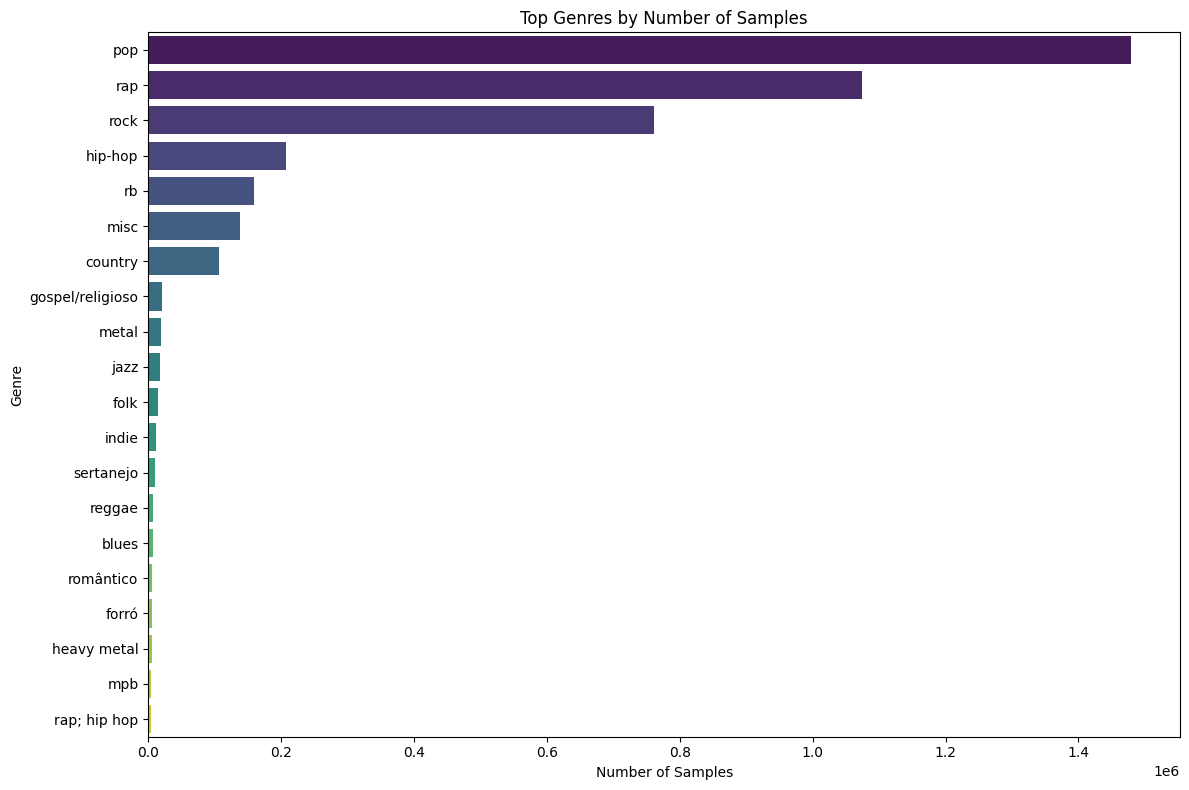

In [6]:
pdf = df.to_pandas()
genre_col, lyrics_col = df.columns[0], df.columns[1]
class_counts = pdf[genre_col].value_counts()
print("Class counts", class_counts)
top_n = 20  
top_classes = class_counts.head(top_n)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_classes.values, y=top_classes.index, palette="viridis")
plt.title("Top Genres by Number of Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()
